# Spectral Analysis

## Functions

In [298]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, fft, interpolate
import pywt
from skimage.metrics import structural_similarity as ssim

from importlib import reload
import dataset.data_preprocessing as dp
reload(dp)

# import functions as f

<module 'dataset.data_preprocessing' from '/Users/ardiansyahnugraha/Documents/Codes/ip-paris-project-datapac/dataset/data_preprocessing.py'>

In [299]:
def get_data(directory, disabled):
    df_meta = dp.get_metadata_df(directory=directory, disabled=disabled)
    left, right, rate = dp.get_data_raw_cycles(directory=directory,
                                               list_joints=['Knee'],
                                               disabled=disabled)

    # df_left, df_right, rate = dp.get_data_normalized_cycles(directory=directory,
    #                                            list_joints=['Knee'],
    #                                            disabled=disabled)
    
    df_rate = pd.DataFrame(rate)
    df_rate.columns = ['Rate']
    df_meta = pd.concat([df_meta, df_rate], axis=1)
    
    # left = np.array(df_left.filter(regex='sagittal'))
    # right = np.array(df_right.filter(regex='sagittal'))

    return df_meta, left, right


In [300]:
def mean_centering(dictionary):
    for key, value in dictionary.items():
        mean_value = sum(value) / len(value)
        dictionary[key] = [item - mean_value for item in value]

In [301]:
def process_data(df_meta, left, right):
    left_dict = {}
    right_dict = {}

    for i in range(len(left)):
        id_patient = df_meta['id_patient'][i]
        if id_patient not in left_dict:
            left_dict[id_patient] = []
        for j in range(len(left[i])):
            left_dict[id_patient].append(left[i][j][1])
    for i in range(len(right)):
        id_patient = df_meta['id_patient'][i]
        if id_patient not in right_dict:
            right_dict[id_patient] = []
        for j in range(len(right[i])):
            right_dict[id_patient].append(right[i][j][1])

    mean_centering(left_dict)
    mean_centering(right_dict)

    df_lc_length = df_meta.groupby(['id_patient'])['Left cycle length'].sum()
    df_lc_length.name = 'Left signal length'
    df_rc_length = df_meta.groupby(['id_patient'])['Right cycle length'].sum()
    df_rc_length.name = 'Right signal length'
    df_disease = df_meta.groupby(['id_patient'])['Disease'].first()
    df_rate = df_meta.groupby(['id_patient'])['Rate'].first()
    
    df_meta_signal = pd.concat([df_disease,
                                 df_lc_length,
                                 df_rc_length,
                                 df_rate,
                                 ],
                                 axis=1)
    
    return df_meta_signal, left_dict, right_dict

In [302]:
def intp_signal(df_meta_signal, dict_right_signal, dict_left_signal):
    dict_leftsig_intp = {}
    dict_rightsig_intp = {}
    dict_ssim = {}

    for (i, left), (j, right) in zip(dict_left_signal.items(), dict_right_signal.items()):
        if len(left) < len(right):
            nleft = np.arange(len(left))
            f = interpolate.interp1d(nleft, left, kind='cubic')
            dict_leftsig_intp[i] = f(np.linspace(0, len(left) - 1, len(right)))
            dict_rightsig_intp[j] = right
        else:
            nright = np.arange(len(right))
            f = interpolate.interp1d(nright, right, kind='cubic')
            dict_rightsig_intp[j] = f(np.linspace(0, len(right) - 1, len(left)))
            dict_leftsig_intp[i] = left
        
        dict_ssim[i] = ssim(np.array(dict_leftsig_intp[i]), 
                                      np.array(dict_rightsig_intp[j]), 
                                      data_range=np.array(dict_rightsig_intp[j]).max() - np.array(dict_rightsig_intp[j]).min())
    
    df_ssim = pd.DataFrame.from_dict(dict_ssim, orient='index', columns=['SSIM'])
    df_meta_signal = pd.concat([df_meta_signal, df_ssim], axis=1)
    # df_meta_signal['Left signal length'][i] = 

    return df_meta_signal, dict_leftsig_intp, dict_rightsig_intp

In [553]:
def plot(df_patient, dict_left, dict_right):
    for index, row in df_patient.iterrows():
        id_patient = index
        disease = row['Disease']
        rate = row['Rate']

        x_left = np.array(dict_left[id_patient])
        x_right = np.array(dict_right[id_patient]) 

        n_left = len(x_left)
        n_right = len(x_right)

        t_right = np.arange(n_right)
        t_left = np.arange(n_left)

        # Create a 2x2 subplot grid
        fig, axs = plt.subplots(2, 4, figsize=(20, 6))

        # Plot time domain for left leg
        axs[0, 0].plot(t_left, x_left)
        axs[0, 0].set_title(f'Original: Left - {id_patient} {disease}')
        axs[0, 0].set_xlabel('Cycle')
        axs[0, 0].set_ylabel('Knee angle (deg)')
        axs[0, 0].spines[['right', 'top']].set_visible(False)

        # Plot time domain for right leg
        axs[1, 0].plot(t_right, x_right)
        axs[1, 0].set_title(f'Original: Right - {id_patient} {disease}')
        axs[1, 0].set_xlabel('Cycle')
        axs[1, 0].set_ylabel('Knee angle (deg)')
        axs[1, 0].spines[['right', 'top']].set_visible(False)

        # Compute FFT
        x_left_fft = fft.fft(x_left)
        x_right_fft = fft.fft(x_right)

        ts = 1.0 / rate
        f_left_fft = fft.fftfreq(n_left, ts)
        f_right_fft = fft.fftfreq(n_right, ts)

        # Plot frequency domain for left leg
        axs[0, 1].stem(f_left_fft[:n_left//2],
                       np.abs(x_left_fft)[:n_left//2],
                       linefmt=':',
                       markerfmt='o',
                       basefmt=' ')
        axs[0, 1].set_title(f'FFT: Left - {id_patient} - {disease}')
        axs[0, 1].set_xlabel('Frequency (Hz)')
        axs[0, 1].set_ylabel('Magnitude')
        axs[0, 1].set_xlim(left=-0.5, right=5.5, auto=True)
        axs[0, 1].spines[['right', 'top']].set_visible(False)

        # Plot frequency domain for right leg
        axs[1, 1].stem(f_right_fft[:n_right//2],
                       np.abs(x_right_fft)[:n_right//2],
                       linefmt=':',
                       markerfmt='o',
                       basefmt=' ')
        axs[1, 1].set_title(f'FFT: Right - {id_patient} {disease}')
        axs[1, 1].set_xlabel('Frequency (Hz)')
        axs[1, 1].set_ylabel('Magnitude')
        axs[1, 1].set_xlim(left=-0.5, right=5.5, auto=True)
        axs[1, 1].spines[['right', 'top']].set_visible(False)


        # Compute CWT
        wavelet = 'gaus1'
        # wavelet = pywt.ContinuousWavelet(wavelet_name)
        scale_left = np.arange(1, n_left + 1)  # Adjust the range of scales as needed
        scale_right = np.arange(1, n_right + 1)  # Adjust the range of scales as needed
        coefficients_left, frequencies_left = pywt.cwt(x_left, scale_left, wavelet)
        coefficients_right, frequencies_right = pywt.cwt(x_right, scale_right, wavelet)
        
        # Plot scalogram for left leg
        im = axs[0, 2].imshow(np.abs(coefficients_left) ** 2,
                         aspect='auto',
                         extent=[0, n_left, frequencies_left[-1], frequencies_left[0]],
                         cmap='jet',
                         interpolation='bilinear')
        axs[0, 2].set_title(f'Wavelet: Left - {id_patient} {disease}')
        axs[0, 2].set_xlabel('Cycle')
        axs[0, 2].set_ylabel('Wavelet Frequency (Hz)')
        axs[0, 2].set_ylim(bottom=0.15)
        axs[0, 2].spines[['top']].set_visible(False)
        plt.colorbar(im, ax=axs[0, 2], label='Magnitude', pad=0.125)
        ax2 = axs[0, 2].twinx()
        ax2.set_ylabel('Original Frequency (Hz)')
        original_freqs = np.fft.fftfreq(len(x_left), d=ts)  # Compute original frequencies
        ax2.set_yticks(np.arange(0, max(original_freqs), 1))  # Adjust as needed
        # ax2.set_ylim(axs[0, 2].get_ylim())  # Sync y-axis limits
        ax2.set_ylim(top=10)

        # Plot scalogram for right leg
        im = axs[1, 2].imshow(np.abs(coefficients_right) ** 2,
                         aspect='auto',
                         extent=[0, n_right, frequencies_right[-1], frequencies_right[0]],
                         cmap='jet')
        axs[1, 2].set_title(f'Wavelet: Right - {id_patient} {disease}')
        axs[1, 2].set_xlabel('Cycle')
        axs[1, 2].set_ylabel('Wavelet Frequency (Hz)')
        axs[1, 2].set_ylim(bottom=0.15)
        axs[1, 2].spines[['right', 'top']].set_visible(False)
        ax2 = axs[1, 2].secondary_yaxis('right', functions=(lambda x: pywt.scale2frequency(wavelet, 1/x) * n_left,
                                                    lambda y: 1/pywt.frequency2scale(wavelet, y / n_left)))
        ax2.set_ylabel('Original Frequency (Hz)')
        plt.colorbar(im, ax=axs[1, 2], label='Magnitude', pad=0.125)        

        ## Spectogram
        f, t, spectr = signal.stft(x_left, fs=rate, window='hann', nperseg=100, noverlap=50)
        cycle = t * rate
        im = axs[0, 3].pcolormesh(cycle, f, np.abs(spectr), shading='gouraud')
        axs[0, 3].set_title(f'STFT: Left - {id_patient} {disease}')
        axs[0, 3].set_xlabel('Cycle')
        axs[0, 3].set_ylabel('Frequency (Hz)')
        axs[0, 3].set_ylim(bottom=0, top=3)
        axs[0, 3].spines[['right', 'top']].set_visible(False)
        plt.colorbar(im, ax=axs[0, 3], label='Power/Frequency (dB/Hz)')

        f, t, spectr = signal.stft(x_right, fs=rate, window='hann', nperseg=100, noverlap=50)
        cycle = t * rate
        im = axs[1, 3].pcolormesh(cycle, f, np.abs(spectr), shading='gouraud')
        axs[1, 3].set_title(f'STFT: Right - {id_patient} {disease}')
        axs[1, 3].set_xlabel('Cycle)')
        axs[1, 3].set_ylabel('Frequency (Hz)')
        axs[1, 3].set_ylim(bottom=0, top=3)
        axs[1, 3].spines[['right', 'top']].set_visible(False)
        plt.colorbar(im, ax=axs[1, 3], label='Power/Frequency (dB/Hz)')

        plt.tight_layout()
        plt.show()

In [304]:
def trend(df_patient, dict_left, dict_right, top):
    top_freq_df = pd.DataFrame(columns=['id_patient',
                                        'top freq left',
                                        'top mag left',
                                        'top freq right',
                                        'top mag right'])

    for index, row in df_patient.iterrows():
        id_patient = index
        rate = row['Rate']

        x_left = np.array(dict_left[id_patient])
        x_right = np.array(dict_right[id_patient])

        # Compute FFT
        x_left_fft = fft.fft(x_left)
        x_right_fft = fft.fft(x_right)
        n_left = len(x_left)
        n_right = len(x_right)
        ts = 1.0 / rate
        f_left_fft = fft.fftfreq(n_left, ts)
        f_right_fft = fft.fftfreq(n_right, ts)

        # Find the top 10 frequencies and magnitudes for left leg
        top_indices_left = np.argsort(np.abs(x_left_fft[:n_left//2]))[::-1][:top]
        top_frequencies_left = f_left_fft[top_indices_left]
        top_magnitudes_left = np.abs(x_left_fft[top_indices_left])

        # Find the top 10 frequencies and magnitudes for right leg
        top_indices_right = np.argsort(np.abs(x_right_fft[:n_right//2]))[::-1][:top]
        top_frequencies_right = f_right_fft[top_indices_right]
        top_magnitudes_right = np.abs(x_right_fft[top_indices_right])
       
        df = pd.DataFrame({'id_patient': id_patient,
                           'top freq left': top_frequencies_left,
                           'top mag left': top_magnitudes_left,
                           'top freq right': top_frequencies_right,
                           'top mag right': top_magnitudes_right})
        top_freq_df = pd.concat([top_freq_df, df],axis=0)

    # print(top_freq_df)
    melted_df_left = top_freq_df[['id_patient', 'top freq left', 'top mag left']].rename(columns={'top freq left': 'frequency', 'top mag left': 'magnitude'})
    melted_df_right = top_freq_df[['id_patient', 'top freq right', 'top mag right']].rename(columns={'top freq right': 'frequency', 'top mag right': 'magnitude'})
    melted_df_left['side'] = 'left'
    melted_df_right['side'] = 'right'
    melted_df = pd.concat([melted_df_left, melted_df_right])
    # print(melted_df)

    # Create the FacetGrid
    grid = sns.FacetGrid(melted_df, col='side', hue='side', palette="viridis")

    # Map the scatter plot onto the grid
    grid.map(plt.scatter, 'frequency', 'magnitude', alpha=0.7)

    # Add legend
    grid.add_legend()

    # Show the plot
    plt.show()

    # return melted_df

In [305]:
def cyc_to_sig(df_meta_cycle, left_cycle, right_cycle):
    dict_left_signal = {}
    dict_right_signal = {}

    for i, (left, right) in enumerate(zip(left_cycle, right_cycle)):
        id_patient = df_meta_cycle['id_patient'][i]
        
        dict_left_signal.setdefault(id_patient, []).extend(left.tolist())
        dict_right_signal.setdefault(id_patient, []).extend(right.tolist())

    mean_centering(dict_left_signal)
    mean_centering(dict_right_signal)
    
    df_lc_length = df_meta_cycle.groupby(['id_patient'])['Left cycle length'].sum()
    df_lc_length.name = 'Left signal length'
    df_rc_length = df_meta_cycle.groupby(['id_patient'])['Right cycle length'].sum()
    df_rc_length.name = 'Right signal length'
    df_disease = df_meta_cycle.groupby(['id_patient'])['Disease'].first()
    df_rate = df_meta_cycle.groupby(['id_patient'])['Rate'].first()

    df_meta_signal = pd.concat([df_disease,
                                 df_lc_length,
                                 df_rc_length,
                                 df_rate],
                                 axis=1)
    
    return df_meta_signal, dict_left_signal, dict_right_signal


## Healthy Control

### Import HC data

In [88]:
dir_HC = "dataset/Sujets sains"
df_meta_cycle_HC, left_cycle_HC, right_cycle_HC = get_data(dir_HC, False)

[==================================================] 100% (52/52)

In [306]:
# df_meta_signal_HC, dict_left_signal_HC, dict_right_signal_HC = cyc_to_sig(df_meta_cycle_HC, left_cycle_HC, right_cycle_HC)
df_meta_signal_HC, dict_left_signal_HC, dict_right_signal_HC = process_data(df_meta_cycle_HC, left_cycle_HC, right_cycle_HC)
df_metasig_HC, dict_leftsig_HC, dict_rightsig_HC = intp_signal(df_meta_signal_HC, dict_left_signal_HC, dict_right_signal_HC)

In [432]:
df_metasig_HC['Disease'].value_counts()

Disease
Corridor         39
HC                6
Aucune            3
Corridor2018      2
                  1
Corridor 2018     1
Name: count, dtype: int64

In [474]:
disease_map = [
    (df_metasig_HC['Disease'].str.contains('Corridor', case=False), 'Corridor'),
    (df_metasig_HC['Disease'].str.contains('HC', case=False), 'HC'),
    (True, 'Other HC')  # Default for any other disease not matched
]

# Apply mapping rules and create new column
df_metasig_HC['Disease Group'] = np.select([condition for condition, _ in disease_map], [value for _, value in disease_map], default='Other HC')


/opt/homebrew/lib/python3.11/site-packages/pywt/_functions.py:204: RuntimeWarning: divide by zero encountered in divide
  return central_frequency(wavelet, precision=precision) / freq


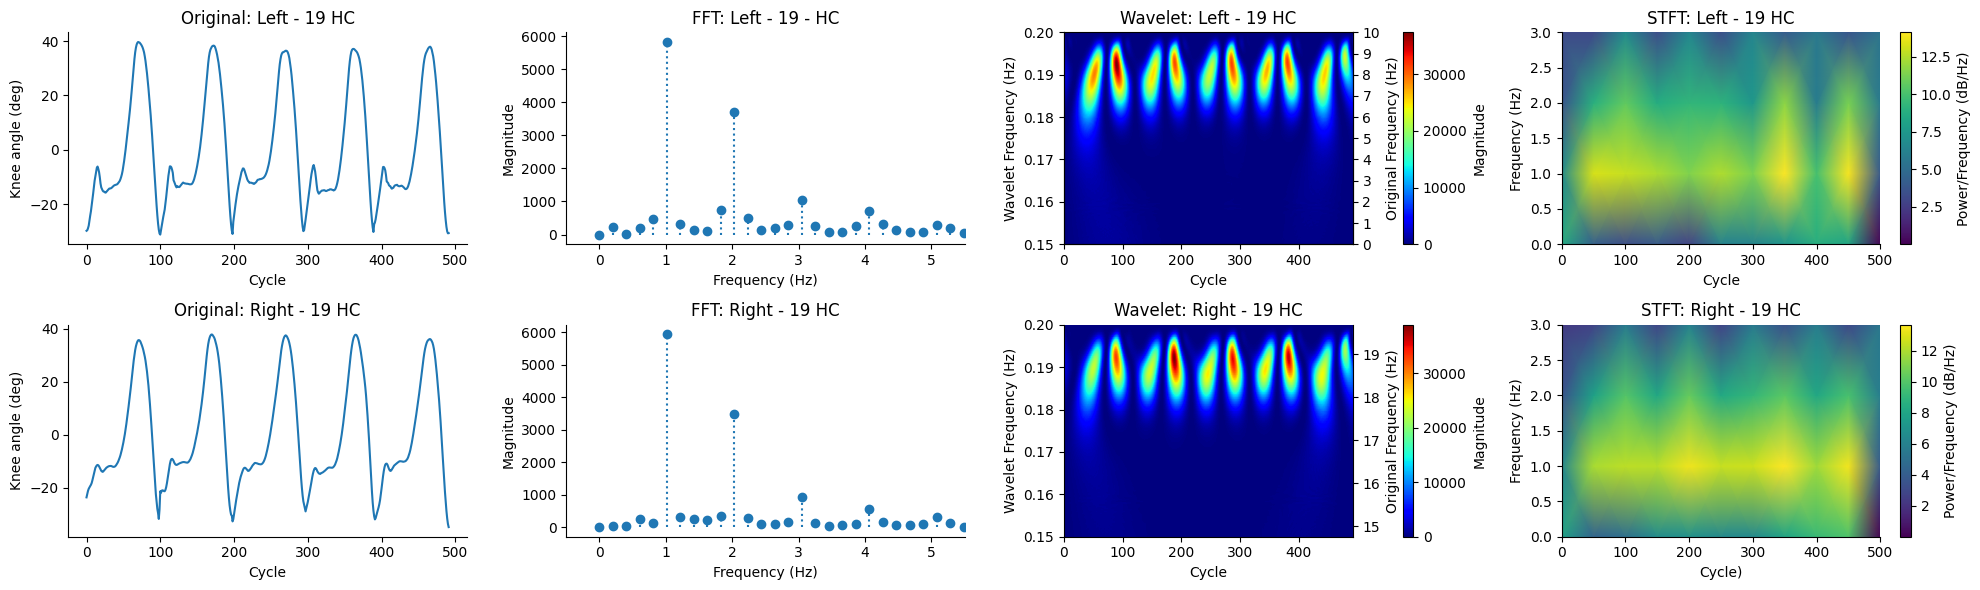

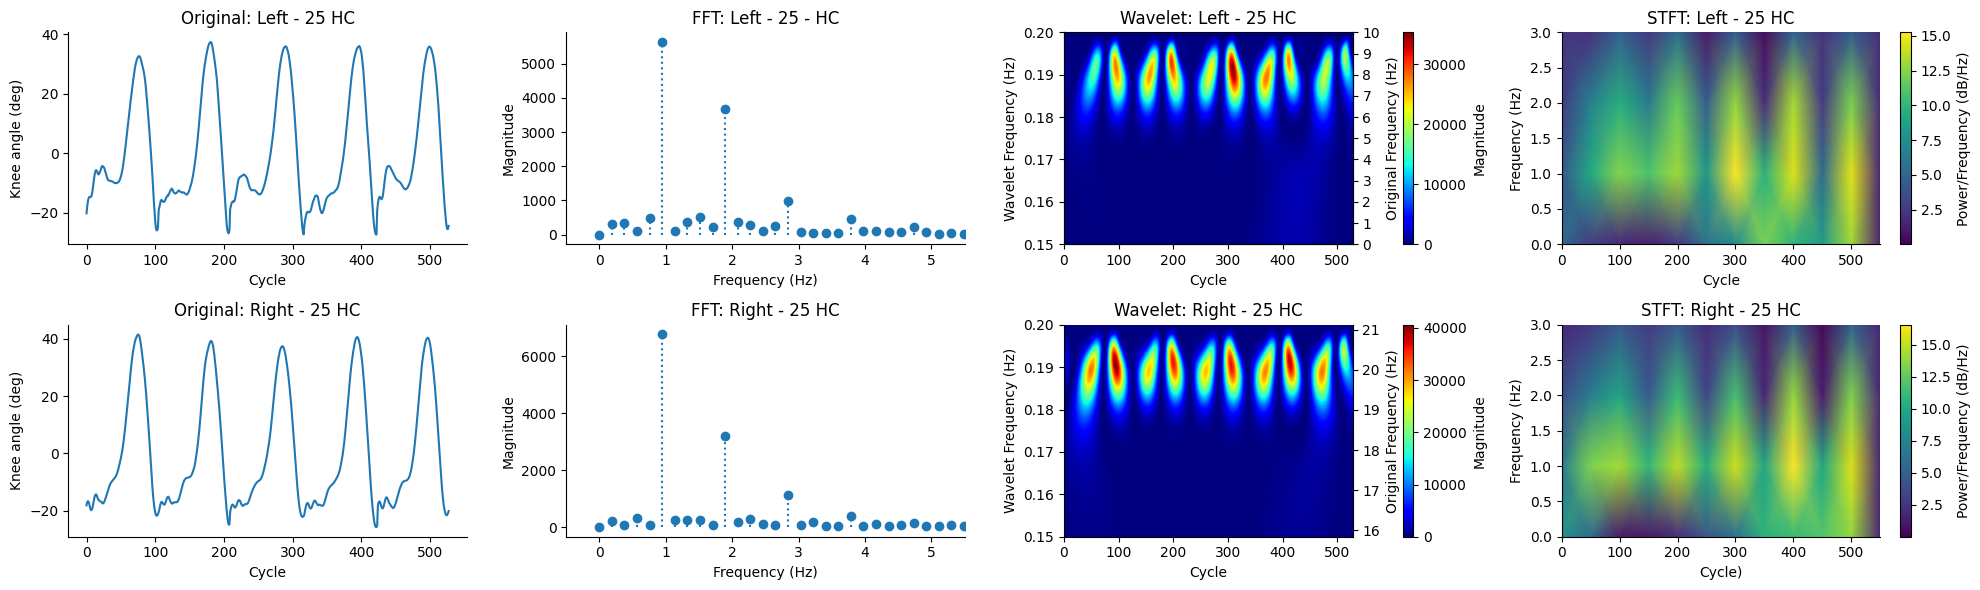

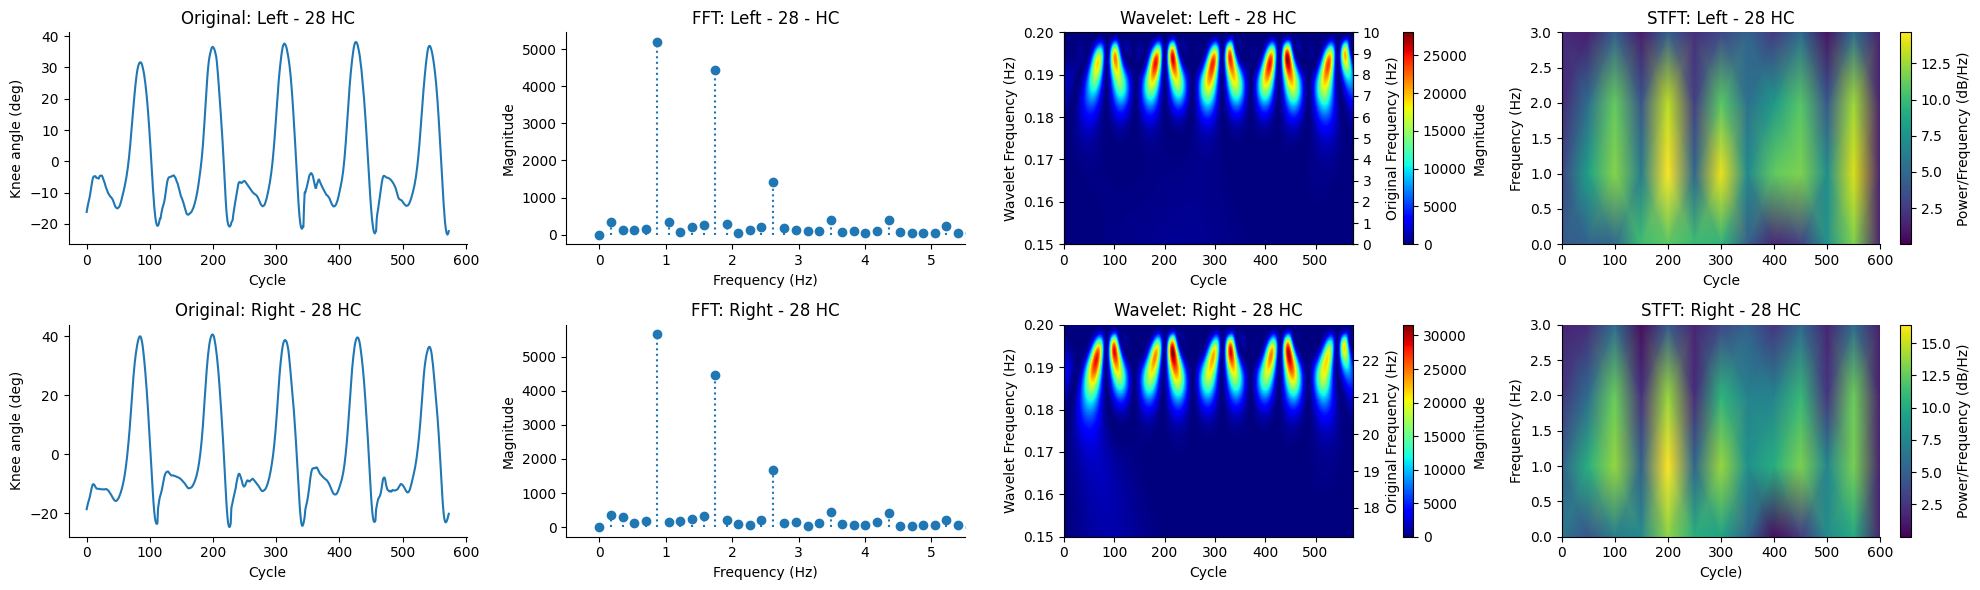

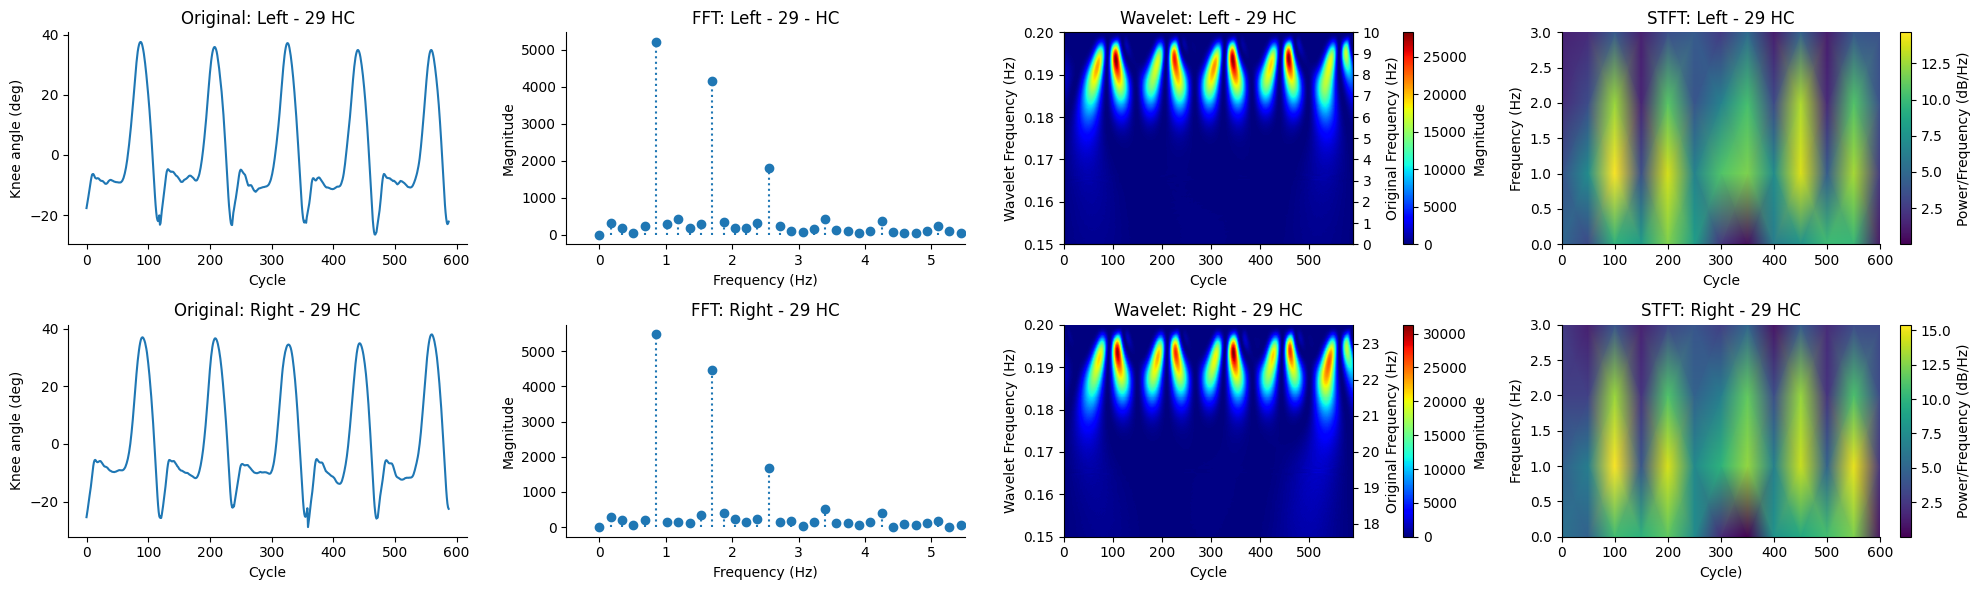

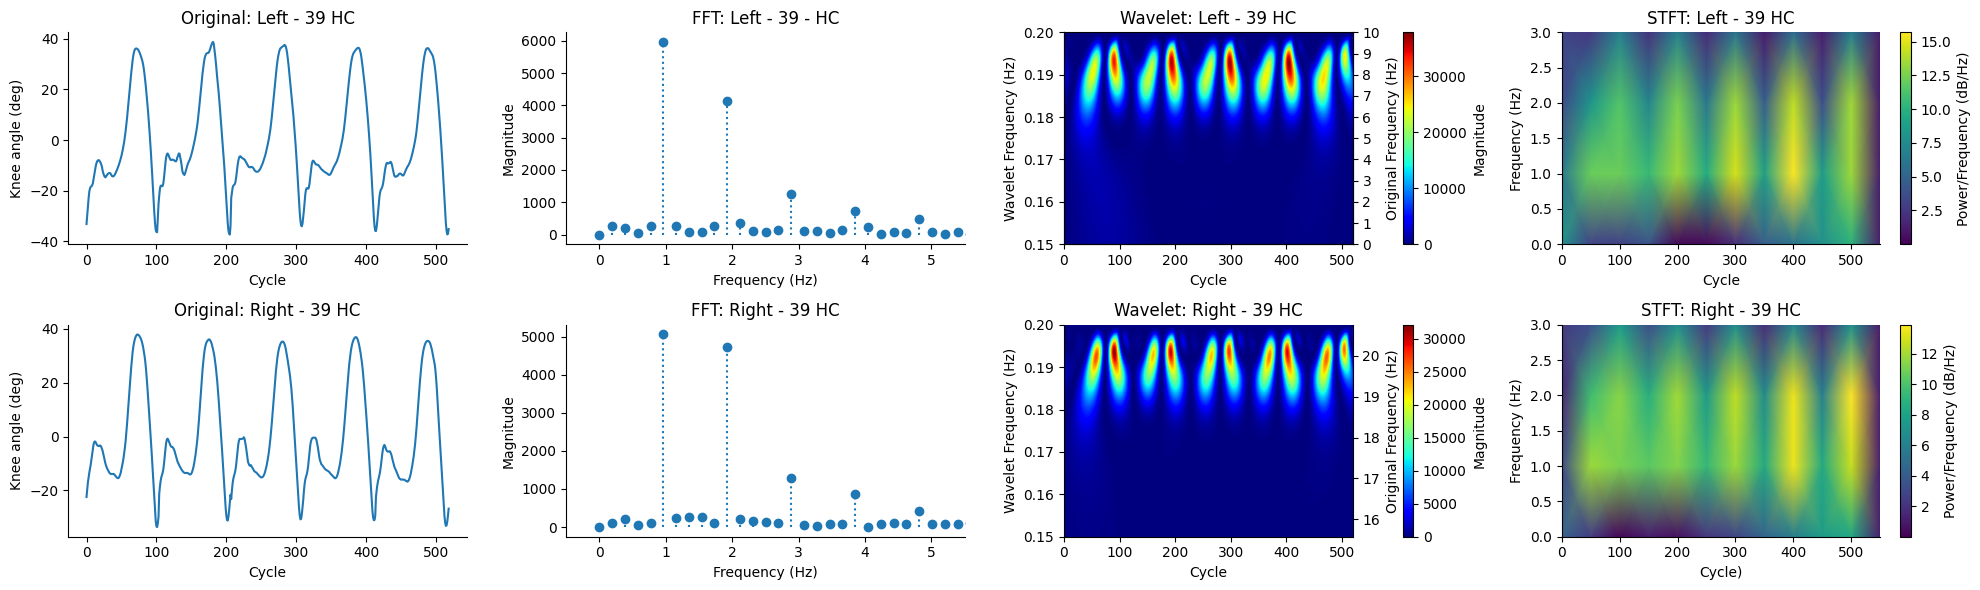

In [554]:
df_patient_HC = df_metasig_HC[df_metasig_HC["Disease Group"] == "HC"].head(5)
plot(df_patient=df_patient_HC, dict_left=dict_leftsig_HC, dict_right=dict_rightsig_HC)

/var/folders/6y/9sn_0x3d041dsl6rwm8hpy300000gn/T/ipykernel_48793/2308066894.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_freq_df = pd.concat([top_freq_df, df],axis=0)


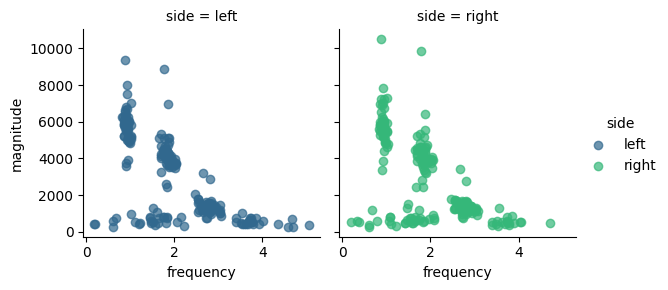

In [313]:
trend(
    df_patient=df_meta_signal_HC,
    dict_left=dict_leftsig_HC,
    dict_right=dict_rightsig_HC,
    top=4,
)

## Pathological Subjects

### Import Pathological data

In [308]:
dir_PT = "dataset/Sujets patho"
df_meta_cycle_PT, left_cycle_PT, right_cycle_PT = get_data(dir_PT, True)

[=                                                 ] 2% (1/40)

[==================================================] 100% (40/40)

In [404]:
df_meta_signal_PT, dict_left_signal_PT, dict_right_signal_PT = process_data(df_meta_cycle_PT, left_cycle_PT, right_cycle_PT)
df_metasig_PT, dict_leftsig_PT, dict_rightsig_PT = intp_signal(df_meta_signal_PT, dict_left_signal_PT, dict_right_signal_PT)

In [405]:
id_patient_map = {name: i for i, name in enumerate(dict_leftsig_PT.keys())}
id_patient_map

{'ZOPPI SOKAL_Nadia': 0,
 'STOFFEL_Jerome': 1,
 'EMERY_Dominique1': 2,
 'BLUTEUX_Corinne': 3,
 'CHOMETTE_Beatrice': 4,
 'GLORIAU_Alexandre': 5,
 'CLAUDOT_Yves': 6,
 'FRERY_Jerome': 7,
 'DIALOUMONA DIALLO_Edgar': 8,
 'BUSNEL_Victor': 9,
 'KLEJNOT_Jean-Claude': 10,
 'EL ADLY_Mahmoud': 11,
 'BOULLOT_Frederic': 12,
 'RABIAUX_Cedric1': 13,
 'CHANFI_Ismail1': 14,
 'CRETI_Chantal': 15,
 'DASSONVILLE_Xavier': 16,
 'BOUTROUE_Didier': 17,
 'GUERRIER_Beatrice': 18,
 'BOURDINAUD_Fabien': 19,
 'QIU_Shouyqing': 20,
 'KHARCHA_Brahim': 21,
 'SCHMITT_Valerie': 22,
 'FAILLE_Carine': 23,
 'PINTO PEREIRA_Paulo': 24,
 'LAPERGUE_Cecile': 25,
 'MAZELLA_Eddy': 26,
 'AUROY_Marc': 27,
 'GOUTTE_Michele': 28,
 'GUILLEMENOT_Sandrine': 29,
 'TAING_Hong': 30,
 'GUMUS_Fatma1': 31,
 'DA COSTA ROMAO_Rogerio': 32,
 'HAMEL_Ghislaisne': 33,
 'SALOH_Abdesslam': 34,
 'CREPY_Matthias': 35,
 'GAUME_Didier': 36,
 'TETU_Carl': 37,
 'BIARNE_Marc': 38,
 'BLANC_Adrien': 39}

In [406]:
df_metasig_PT['patient_id'] = df_metasig_PT.index.map(lambda x: id_patient_map.get(x))

In [417]:
df_metasig_PT = df_metasig_PT.set_index('patient_id')

In [410]:
dict_leftsig_PT = {id_patient_map[name]: value for name, value in dict_leftsig_PT.items()}
dict_leftsig_PT

{0: [-5.156121383727157,
  -7.2403934726545565,
  -8.913617172356215,
  -10.11098805675493,
  -10.824874933098435,
  -11.19652615011761,
  -11.111509676943818,
  -10.533187412688598,
  -9.602232543533177,
  -8.39114812430083,
  -7.030402688561544,
  -5.693386365600684,
  -4.59584409926558,
  -3.8417950682139015,
  -3.4628241257478116,
  -3.5895935389674527,
  -4.092977410040451,
  -4.791413459203838,
  -5.677990044917426,
  -6.707544304385191,
  -7.593661994207597,
  -8.501092266695892,
  -9.410152861993357,
  -10.09672374936924,
  -10.632818057179637,
  -11.120282440173156,
  -11.484329067138923,
  -11.82177694664087,
  -12.193190456206423,
  -12.538409789989938,
  -12.87681253551272,
  -13.222125014987807,
  -13.435204291381027,
  -13.745126672088693,
  -14.00934866995164,
  -14.186467399686848,
  -14.286316526089998,
  -14.405340643161306,
  -14.464236938498601,
  -14.44354370284555,
  -14.521575944750808,
  -14.556640357619784,
  -14.609059165215605,
  -14.60767952671678,
  -14.656

In [411]:
dict_rightsig_PT = {id_patient_map[name]: value for name, value in dict_rightsig_PT.items()}
dict_rightsig_PT

{0: array([ -3.51702779,  -4.62806946,  -5.63798717,  -6.34955909,
         -6.95432523,  -7.37286149,  -7.74250145,  -8.02105818,
         -8.24889958,  -8.26711536,  -8.05442155,  -7.48723321,
         -6.67794251,  -5.90263543,  -5.36751934,  -5.24467489,
         -5.7035194 ,  -6.69262809,  -7.95556396,  -9.39102592,
        -10.93841207, -12.44662811, -13.87809655, -15.43199194,
        -17.12695097, -18.92865879, -20.82201992, -22.622835  ,
        -23.99874535, -24.7280013 , -24.71308592, -23.94465621,
        -22.68520681, -21.34021133, -20.22650896, -19.57417522,
        -19.41580297, -19.59353454, -19.92751293, -20.19770184,
        -20.24400504, -20.1094091 , -19.88499913, -19.58997288,
        -19.30409098, -19.10722627, -18.98600683, -18.93697462,
        -18.91141282, -18.83425749, -18.60422238, -18.2236311 ,
        -17.62064964, -16.83137006, -15.98426709, -15.05904557,
        -13.99500982, -12.91065684, -11.76383245, -10.5022277 ,
         -9.16400078,  -7.83786694,  

In [425]:
df_metasig_PT.Disease.value_counts()

Disease
SEP                                          7
Tetraplegie incomplete                       3
Glioblastome                                 1
AVC hemi gauche                              1
Sjogren Larsson                              1
AVC-->HÃ©mi Gauche                           1
SEP EDSS 3,5                                 1
AVC --> hemi gauche                          1
AVC--> Hemiplegie gauche spastique           1
AVC --> Hemiplegie gauche                    1
AVC Hemi droite                              1
HemiplÃ©gie droite                           1
SEP EDSS5                                    1
AVC hemi droite                              1
HÃ©miplÃ©gie droite                          1
TÃ©traplÃ©gie incomplÃ©te                    1
TC hemi gauche                               1
Tetraparesie incomplete                      1
TC--> Hemiplegie gauche                      1
Rupture anÃ©vrisme -->hÃ©miplÃ©gie droite    1
TI                                           1
AVC H

In [472]:
disease_map = [
    (df_metasig_PT['Disease'].str.contains('mipl', case=False), 'Hemiplegia'),
    (df_metasig_PT['Disease'].str.contains('hemi ', case=False), 'Hemiplegia'),
    (df_metasig_PT['Disease'].str.contains('trapl', case=False), 'Tetraplegia'),
    (df_metasig_PT['Disease'].str.contains('TI', case=False), 'Tetraplegia'),
    (df_metasig_PT['Disease'].str.contains('parapl', case=False), 'Paraplegia'),
    (df_metasig_PT['Disease'].str.contains('mipar', case=False), 'Hemiparesis'),
    (df_metasig_PT['Disease'].str.contains('rapar', case=False), 'Tetraparesis'),
    (df_metasig_PT['Disease'].str.contains('SEP', case=False), 'SEP'),
    (True, 'Other PT')  # Default for any other disease not matched
]

# Apply mapping rules and create new column
df_metasig_PT['Disease Group'] = np.select([condition for condition, _ in disease_map], [value for _, value in disease_map], default='Other PT')


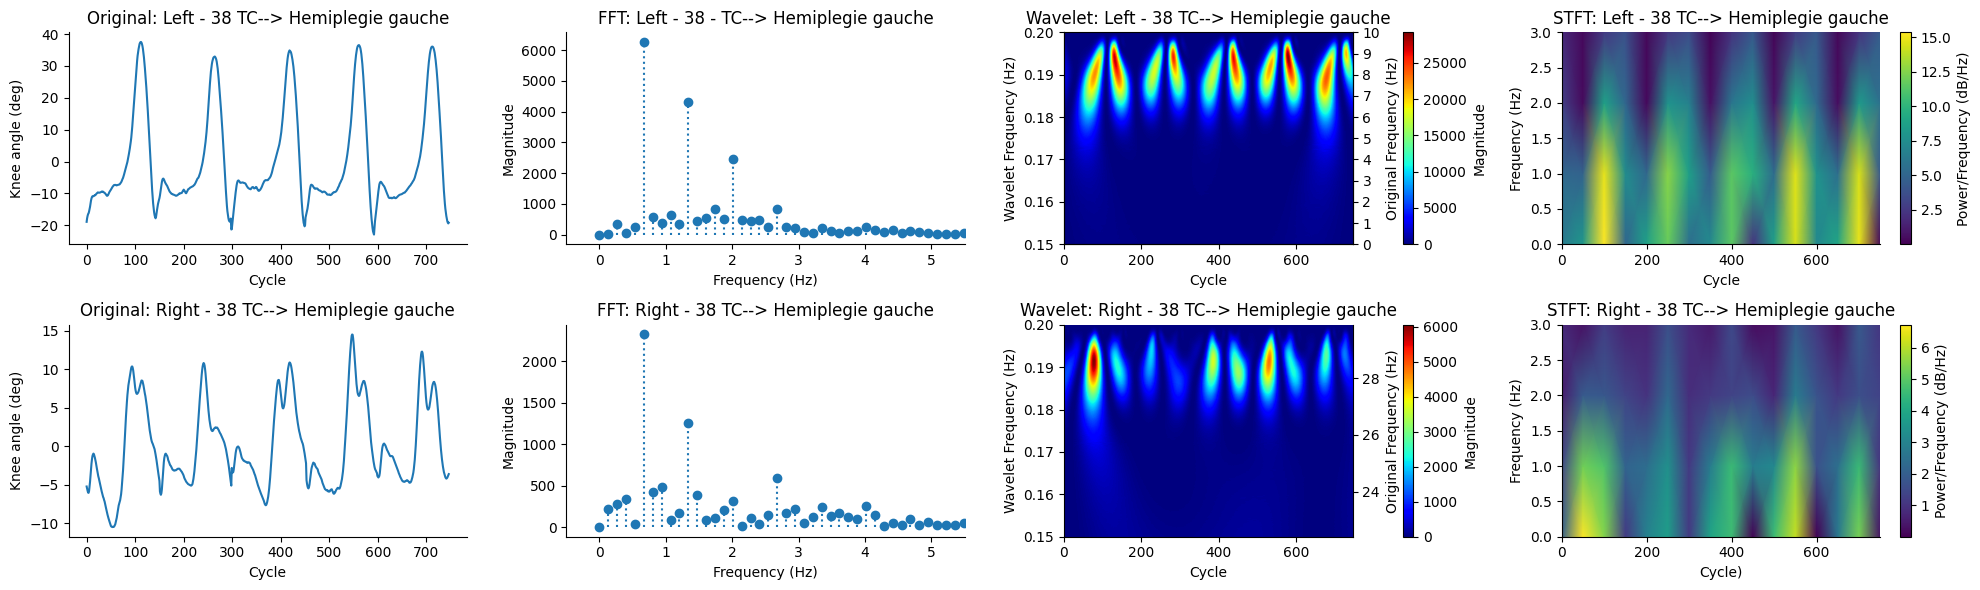

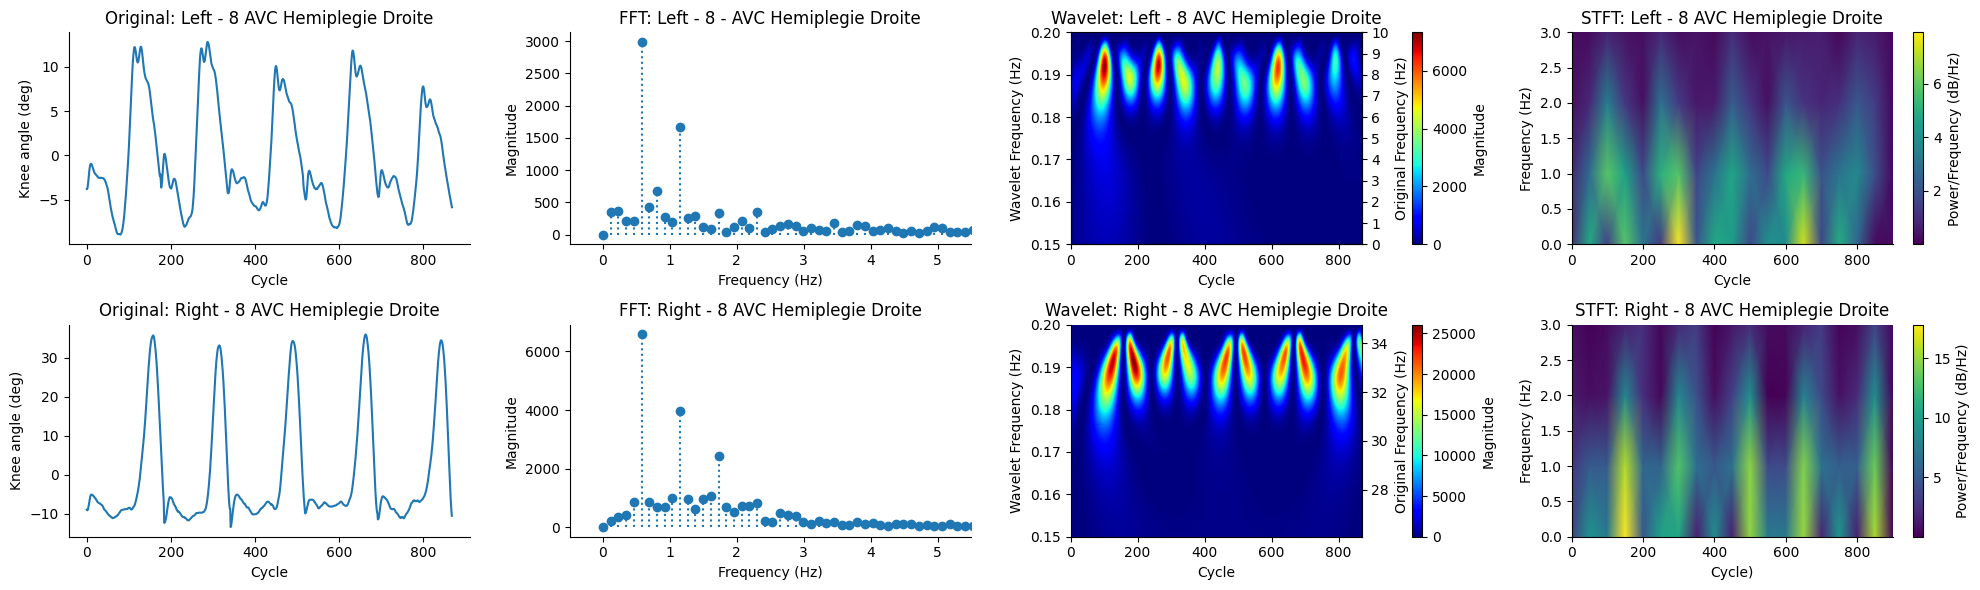

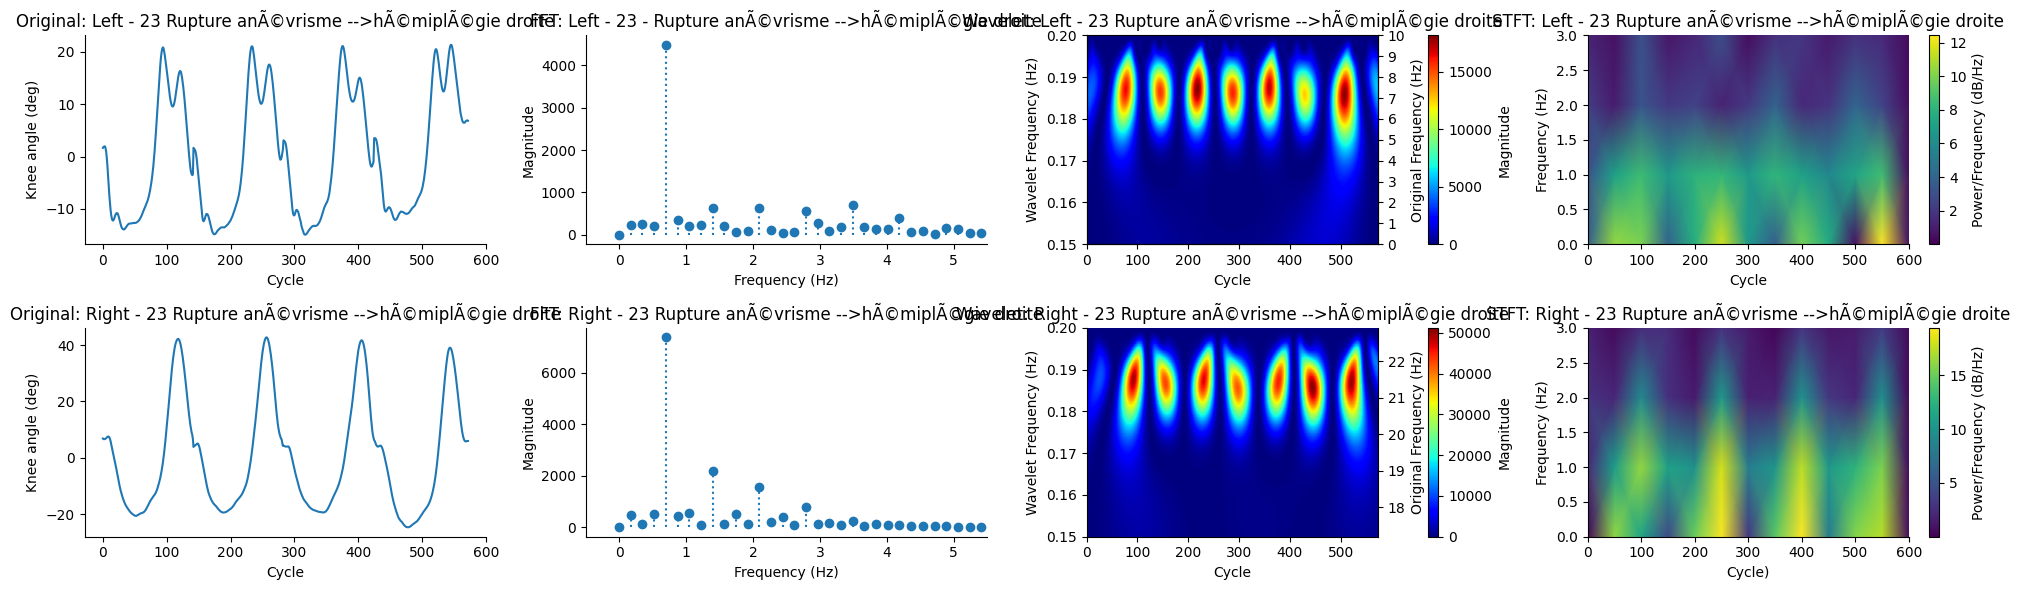

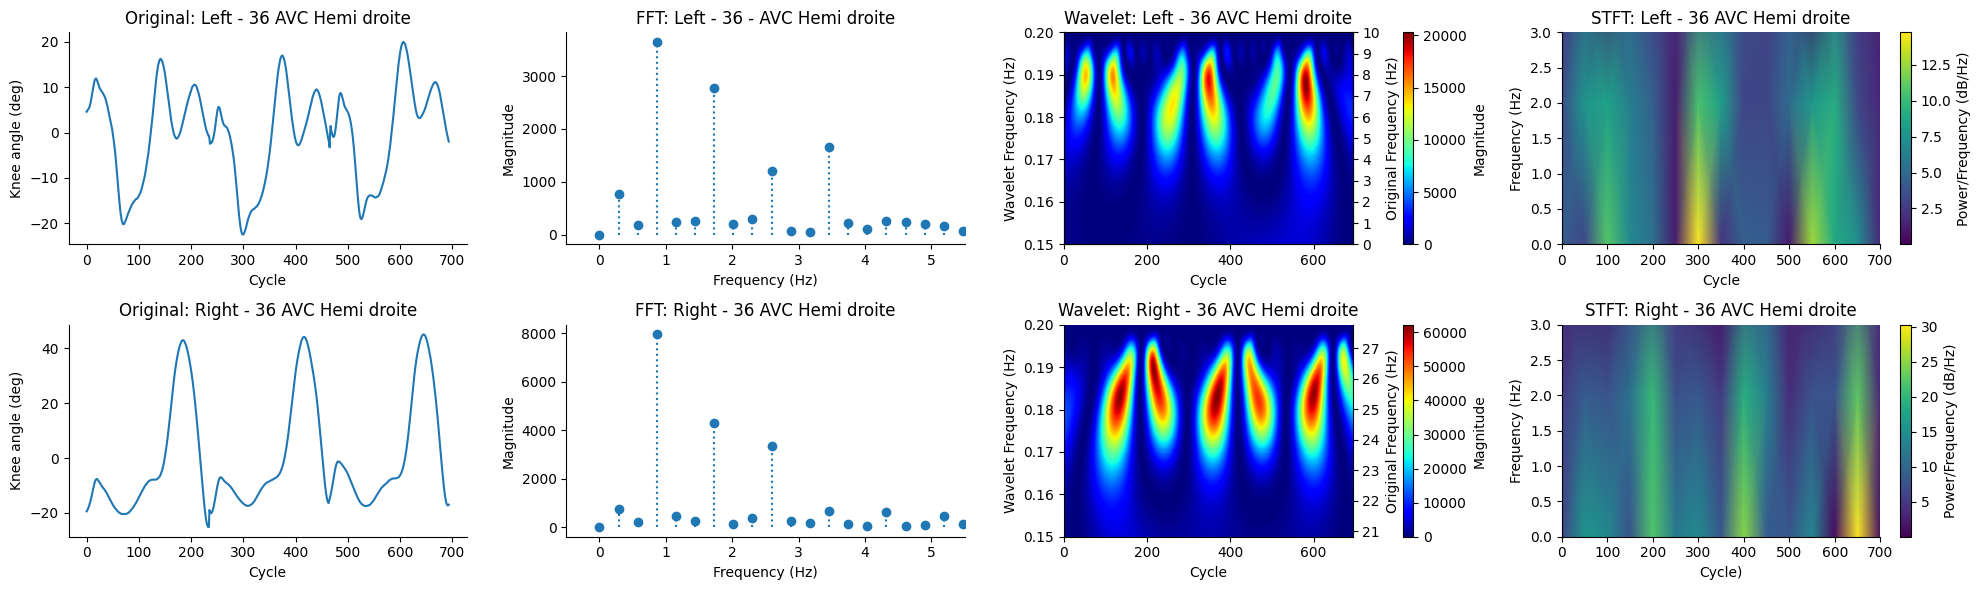

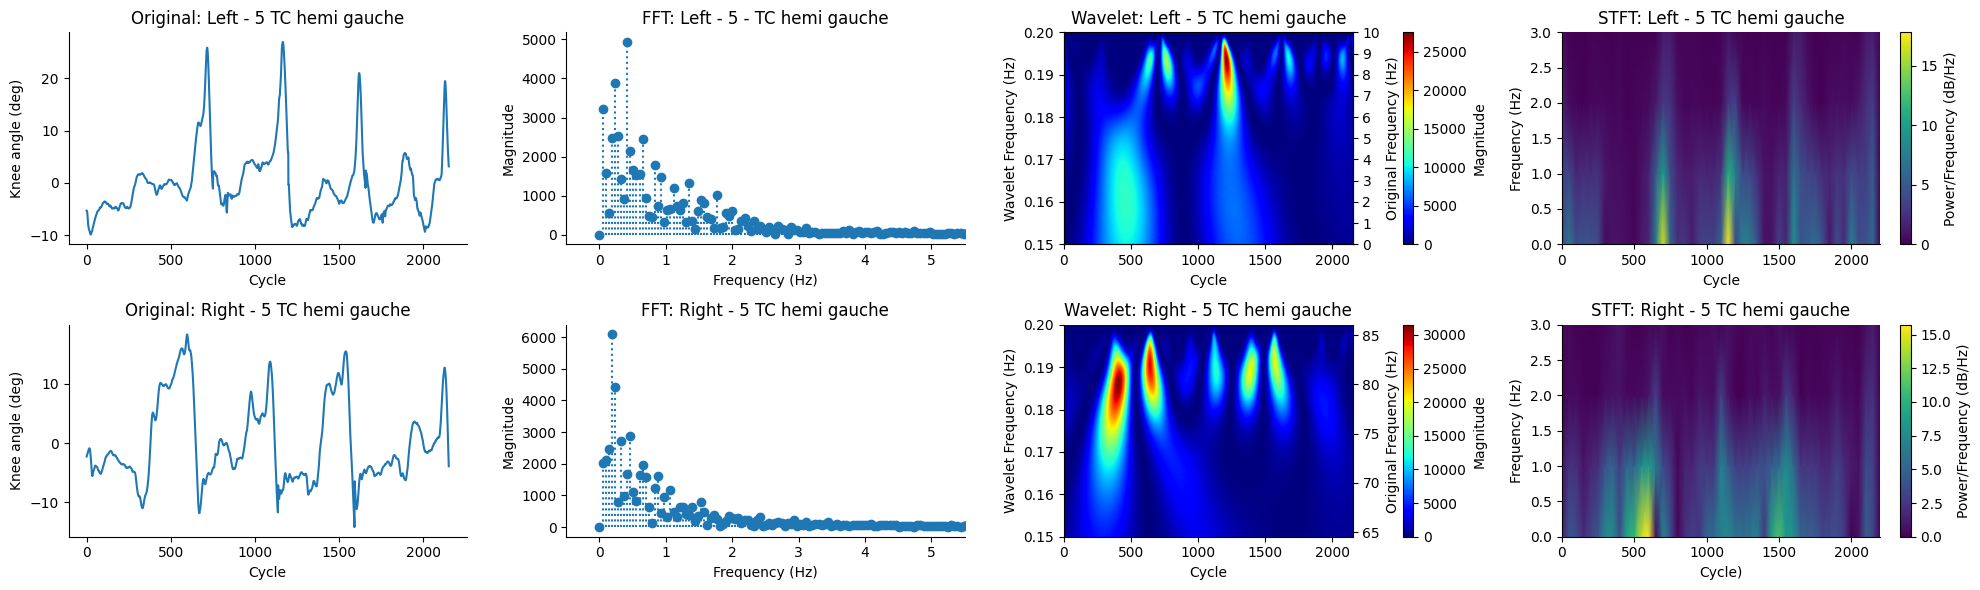

In [555]:
df_patient_PT = df_metasig_PT[df_metasig_PT["Disease Group"] == "Hemiplegia"].head(5)
plot(df_patient=df_patient_PT, dict_left=dict_leftsig_PT, dict_right=dict_rightsig_PT)

/var/folders/6y/9sn_0x3d041dsl6rwm8hpy300000gn/T/ipykernel_48793/2308066894.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_freq_df = pd.concat([top_freq_df, df],axis=0)


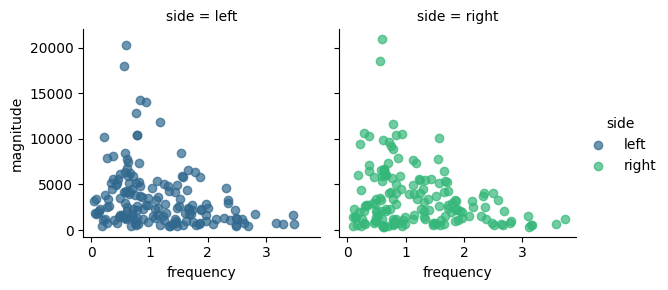

In [312]:
trend(
    df_patient=df_meta_signal_PT,
    dict_left=dict_leftsig_PT,
    dict_right=dict_rightsig_PT,
    top=4,
)

## Structural Similarity Index  (SSIM) between Left and Right Leg

### SSIM per Population Group

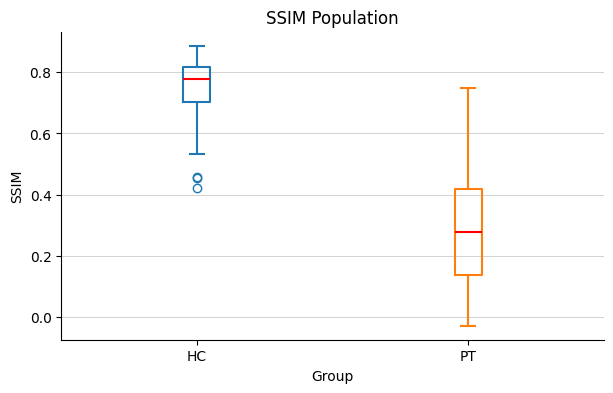

In [552]:
df_metasig_HC['Group'] = 'HC'
df_metasig_PT['Group'] = 'PT'
combined_df = pd.concat([df_metasig_HC, df_metasig_PT])
order = combined_df.groupby(['Group'])['SSIM'].median().sort_values(ascending=False).index
fig, axs = plt.subplots(figsize=(7, 4))
sns.boxplot(data=combined_df, x='Group', y='SSIM', order=order,
            width=0.1, fill=False, hue='Group',
            medianprops={"color": "r"})
axs.spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linewidth=0.4)
plt.title('SSIM Population')
plt.show()

### SSIM per Pathological Type

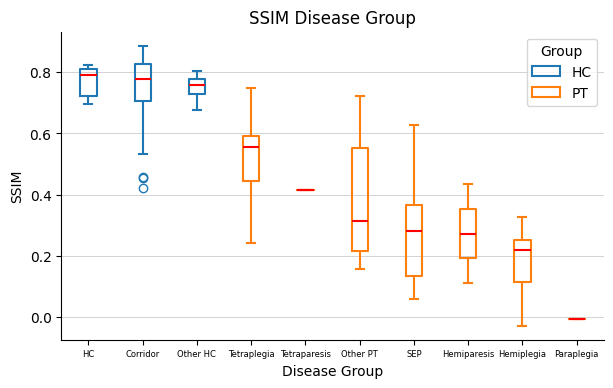

In [551]:
fig, axs = plt.subplots(figsize=(7, 4))
order = combined_df.groupby(['Disease Group'])['SSIM'].median().sort_values(ascending=False).index
sns.boxplot(data=combined_df, x='Disease Group', y='SSIM', order=order,
            width=0.3, fill=False, hue='Group',
            medianprops={"color": "r"})
axs.spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linewidth=0.4)
plt.xticks(fontsize=6)
plt.title('SSIM Disease Group')
plt.show()